# Simple Voice Command Recognition

## Dataset:
 - 1 second wav file of simple commands : "yes", "no", "up", "down", ... etc
 - ~65k training clips, total of ~2G in size
 - 12 target labels

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

## Data processing
- padding/chopping
- Spectrogram
    - regular log spectrogram
    - Mel power spectrogram
    - filterbanks, Mel Frequency Cepstral Coefficient, ... etc

In [3]:
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
import keras

Using TensorFlow backend.


In [8]:
from glob import glob
import gc
import re

In [4]:
# Setting up file paths
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

#src folders
root_path = r'.'
out_path = r'.'
model_path = r'.'
train_data_path = os.path.join(root_path, 'train', 'audio')
test_data_path = os.path.join(root_path, 'test', 'audio')

## Building spectrogram:
- Scipy Signal Spectrogram
    - [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html)

In [5]:
# Function that takes in audio from readwav and turn into spectrogram using scipy
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

## Visualization

Text(0.5,0,'Seconds')

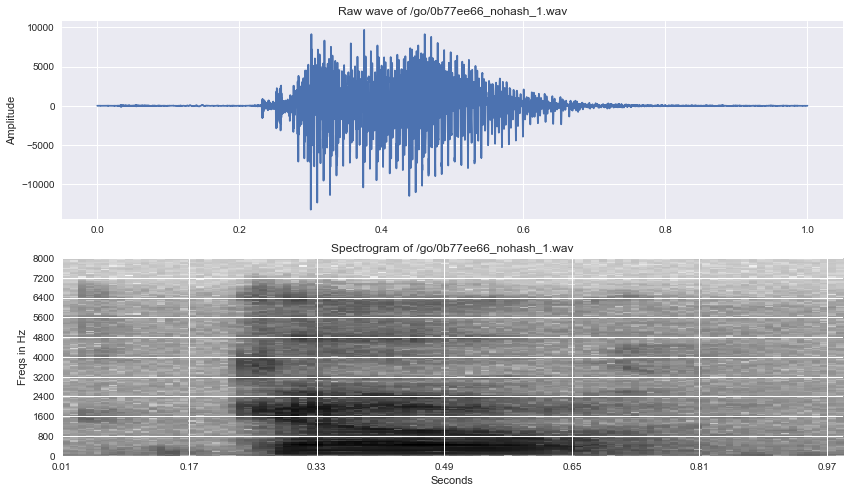

In [31]:
train_audio_path = './train/audio/'
filename = '/go/0b77ee66_nohash_1.wav'
# read audio
eg_sample_rate, eg_samples = wavfile.read(str(train_audio_path) + filename)
# turn into spectrogram
freqs, times, spectrogram = log_specgram(eg_samples, eg_sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, eg_sample_rate/len(eg_samples), eg_sample_rate), eg_samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

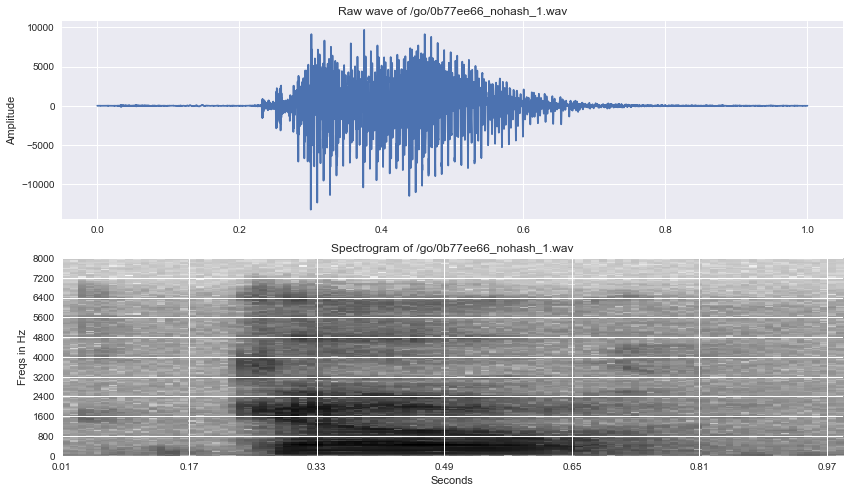

In [32]:
from IPython.display import Image
Image("spectogram.png")

In [25]:
four_samples = ['/go/1aed7c6d_nohash_0.wav', '/stop/0c40e715_nohash_0.wav', '/up/1ffd513b_nohash_0.wav', '/down/0ab3b47d_nohash_0.wav']

## Visualization of spectogram for different labels

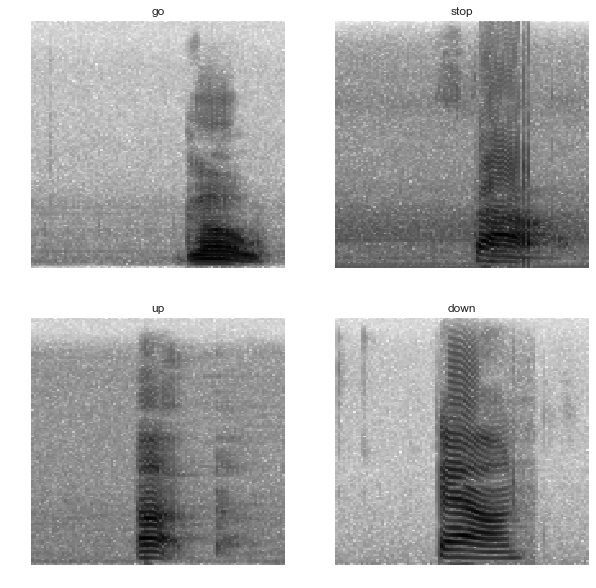

In [27]:
fig = plt.figure(figsize=(10,10))

# for each of the samples
for i, filepath in enumerate(four_samples):
    # Make subplots
    plt.subplot(2,2,i+1)
    
    # pull the labels
    label = filepath.split('/')[-2]
    plt.title(label)
    
    filepath = str(train_audio_path) + filepath
    # create spectogram
    samplerate, test_sound  = wavfile.read(filepath)
    _,_, spectrogram = log_specgram(test_sound, samplerate)
    
    plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.axis('off')

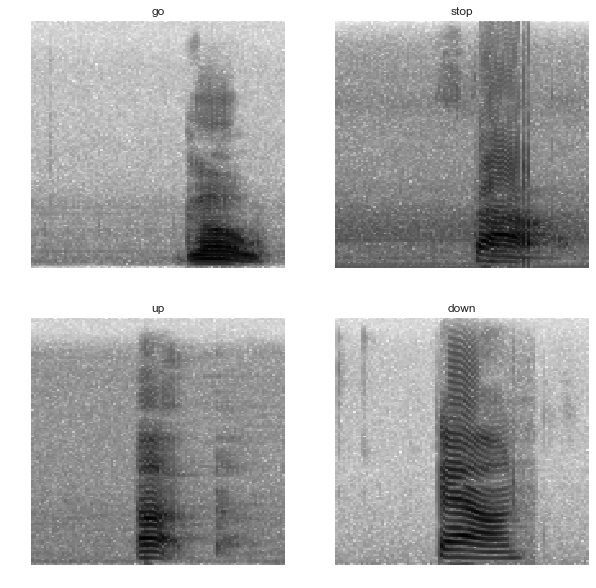

In [33]:
Image("4class.png")

In [6]:
def list_wavs_fname(dirpath, ext='wav'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

In [7]:
# pad audio if samples from readwav is shorter 
def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

# pad audio if samples from readwav is longer 
def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

# label the files 
def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

In [10]:
from sklearn.metrics import confusion_matrix

In [11]:
def to_cat(input_tensor):
    result = np.zeros_like(input_tensor)
    result[np.arange(len(input_tensor)), input_tensor.argmax(1)] = 1
    return result

In [9]:
labels, fnames = list_wavs_fname(train_data_path)

new_sample_rate = 8000
y_train = []
x_train = []

for label, fname in zip(labels, fnames):
    # read each wav file
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
    # it too short, pad
    samples = pad_audio(samples)
    # if too long, chop
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
    else: n_samples = [samples]
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        y_train.append(label)
        x_train.append(specgram)
x_train = np.array(x_train)
x_train = x_train.reshape(tuple(list(x_train.shape) + [1]))
y_train = label_transform(y_train)
label_index = y_train.columns.values
y_train = y_train.values
y_train = np.array(y_train)
del labels, fnames
gc.collect()

./train/audio


/Users/fanggot/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:2223: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/Users/fanggot/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:2225: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/Users/fanggot/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:2230: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

7

In [12]:
input_shape = (99, 81, 1)
nclass = 12

inp = Input(shape=input_shape)
norm_inp = BatchNormalization()(inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(norm_inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Flatten()(img_1)

dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

model = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

# model.compile(optimizer=opt, loss=losses.binary_crossentropy)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy)
model.summary()

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=2017)
model.fit(x_train, y_train, batch_size=16, validation_data=(x_valid, y_valid), epochs=3, shuffle=True)

# model.save(os.path.join(model_path, 'cnn.model'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 99, 81, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 81, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 80, 8)         40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 79, 8)         264       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 39, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 39, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 37, 16)        1168      
__________

## Model structure
- Treating like an image classification problem

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 99, 81, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 81, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 80, 8)         40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 79, 8)         264       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 39, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 39, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 37, 16)        1168      
__________

## Evaluation
- Confusion matrix
- Accuracy
- F1 Score

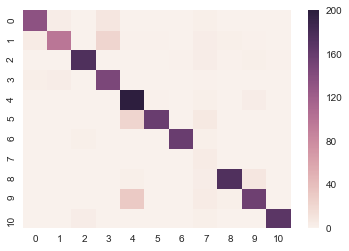

In [14]:
y_valid_pred = model.predict(x_valid)
y_valid_pred_cat = to_cat(y_valid_pred)
confusion_result = confusion_matrix(y_valid.argmax(1), y_valid_pred_cat.argmax(1))
mask = np.ones_like(confusion_result, dtype=bool)
mask[[9]] = False
mask[:, 9] = False
sns.heatmap(confusion_result[mask].reshape(11,-1))

In [15]:
from sklearn.metrics import accuracy_score, f1_score

In [16]:
accuracy_score(y_valid.argmax(1), y_valid_pred_cat.argmax(1))

0.8676946800308404

In [17]:
f1_score(y_valid.argmax(1), y_valid_pred_cat.argmax(1), average='macro')

0.7243643551520383

## Next steps:
- Trying different input features
    - Mel power spectogram
    - MFCC
    - Filterbanks
- Tune hyperparameters
- Try different structure:
    - Recurrent instead of / on top of Convolutional